In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import h5py

import pandas as pd
from tqdm import tqdm

import sys
sys.path.append('../')
from tracker import loadAntData, pltsaveall

From tracker/_init__.py:
SLEAP not detected; make sure to install SLEAP if intending to use postprocessing notebook. Otherwise, ignore this message.


In [2]:
dataFile = '/home/jack/Workspaces/data/ant_tracking/ant_dataset_1_2026-02-01.h5'

minimumLength = 0 # seconds
smoothingWindow = 9 # frames
maximumTimeSkip = 10 # frames

excludeOutliers = True
excludeShortSegments = False
excludeObjects = True

padding = None # mm
inversePadding = None # mm

dataArr, timeArr, metadataArr = loadAntData(dataFile, minimumLength=minimumLength,
                                            smoothingWindow=smoothingWindow, maximumTimeSkip=maximumTimeSkip,
                                            excludeOutliers=excludeOutliers, excludeShortSegments=excludeShortSegments,
                                            excludeObjects=excludeObjects,
                                            borderPadding=padding, inverseBorderPadding=inversePadding,
                                            debug=True)

Loading SLEAP data: 100%|██████████████████| 1434/1434 [00:01<00:00, 833.93it/s]


Loaded 1254 segments!


## Total recording time

In [3]:
totalTime = 0

for i in range(len(timeArr)):
    totalTime += timeArr[i][-1] - timeArr[i][0]

print(f'Trajectory data include a total of {totalTime/60/60:.4} hours of footage.')

Trajectory data include a total of 24.09 hours of footage.


## Length of segments

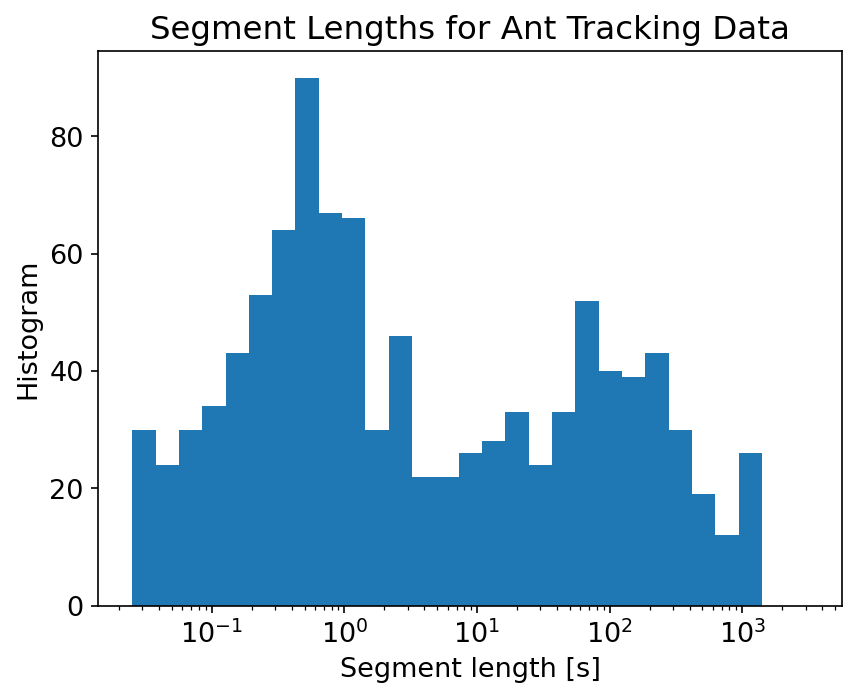

In [4]:
bins = np.logspace(-1.6, 3.5, 30)
segmentLengthArr = np.array([t[-1] - t[0] for t in timeArr])

plt.hist(segmentLengthArr, bins=bins)

if minimumLength > 0 and excludeShortSegments:
    plt.axvline(minimumLength, linestyle='--', c='black', label=f'$t_{min} = {minimumLength}$ s')
    plt.legend()

#plt.yscale('log')
plt.xscale('log')
plt.xlabel('Segment length [s]')
plt.ylabel('Histogram')
plt.title('Segment Lengths for Ant Tracking Data')
pltsaveall('01_SegmentLength')
plt.show()

## Fraction of time lost

Calculate how much data you would lose by removing all segments shorter than a certain duration, `testMinimumLength`. In general, most of the data is contained in longer segments, so it is usually a fraction of a percentage.

In [5]:
testMinimumLength = 5 # seconds

badIndices = np.where(segmentLengthArr < testMinimumLength)[0]
print(f'Found {len(badIndices)} segments that are shorter than {testMinimumLength} seconds.')

removedTime = np.sum(segmentLengthArr[badIndices])
print(f'Removing those segments removes {removedTime:.4} seconds of data total, representing {removedTime / np.sum(segmentLengthArr) * 100:.2}% of the data.')

Found 829 segments that are shorter than 5 seconds.
Removing those segments removes 496.6 seconds of data total, representing 0.57% of the data.


## Number of segments per video

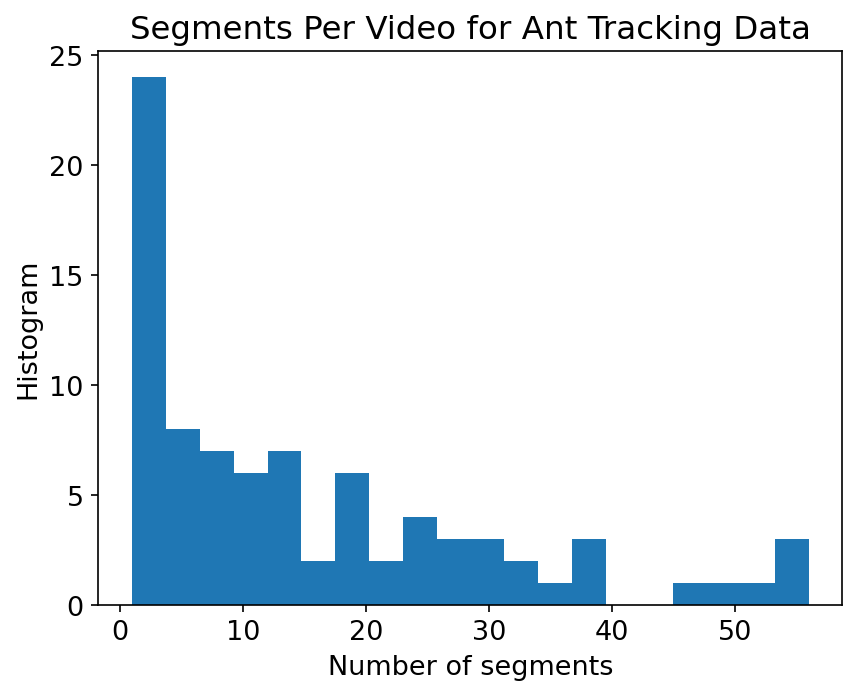

In [6]:
uniqueTrials = np.unique([m["dataset"] for m in metadataArr])
indexDict = dict(zip(uniqueTrials, np.arange(len(uniqueTrials))))

segmentTrialIdentity = np.array([indexDict[metadataArr[l]["dataset"]] for l in range(len(dataArr))])

segmentsPerTrialArr = np.array([len(np.where(segmentTrialIdentity == i)[0]) for i in range(len(uniqueTrials))])

plt.hist(segmentsPerTrialArr, bins=20)
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Number of segments')
plt.ylabel('Histogram')
plt.title('Segments Per Video for Ant Tracking Data')
pltsaveall('01_SegmentsPerVideo')
plt.show()

## Total tracked time for each video

In [7]:
uniqueTrials = np.unique([m["dataset"] for m in metadataArr])
totalTimePerTrialArr = np.zeros(len(uniqueTrials))
indexDict = dict(zip(uniqueTrials, np.arange(len(uniqueTrials))))

for i in tqdm(range(len(dataArr))):
    totalTimePerTrialArr[indexDict[metadataArr[i]["dataset"]]] += timeArr[i][-1] - timeArr[i][0]

100%|███████████████████████████████████| 1254/1254 [00:00<00:00, 587343.07it/s]


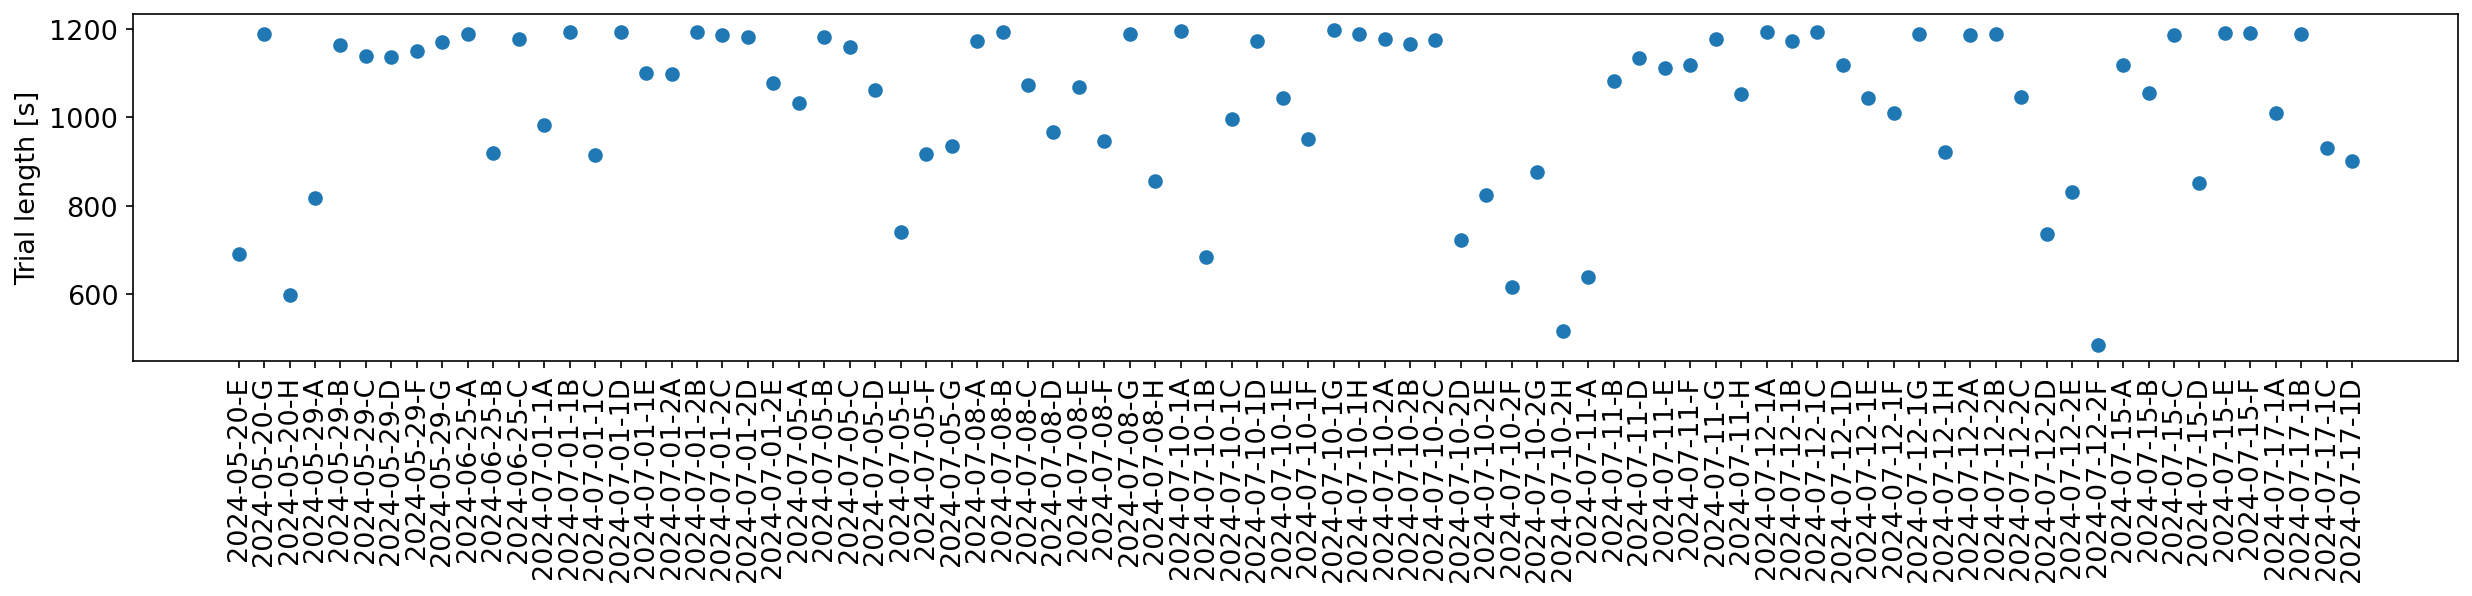

In [8]:
plt.scatter(np.arange(len(uniqueTrials)), totalTimePerTrialArr)
plt.xticks(np.arange(len(uniqueTrials)), uniqueTrials, rotation=90)
plt.gcf().set_size_inches((20,3))
plt.ylabel('Trial length [s]')
plt.show()